In [1]:
import os
import pandas as pd
import pprint

import tensorflow as tf
import tensorflow.contrib.slim as slim

from data_model_jg import StockDataSet
from model_rnn import LstmRNN

In [2]:
flags = tf.app.flags
flags.DEFINE_integer("stock_count", 100, "Stock count [100]")
flags.DEFINE_integer("input_size", 5, "Input size [5]")
flags.DEFINE_integer("num_steps", 30, "Num of steps [30]")
flags.DEFINE_integer("num_layers", 1, "Num of layer [1]")
flags.DEFINE_integer("lstm_size", 128, "Size of one LSTM cell [128]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
flags.DEFINE_float("keep_prob", 0.8, "Keep probability of dropout layer. [0.8]")
flags.DEFINE_float("init_learning_rate", 0.001, "Initial learning rate at early stage. [0.001]")
flags.DEFINE_float("learning_rate_decay", 0.99, "Decay rate of learning rate. [0.99]")
flags.DEFINE_integer("init_epoch", 5, "Num. of epoches considered as early stage. [5]")
flags.DEFINE_integer("max_epoch", 50, "Total training epoches. [50]")
flags.DEFINE_integer("embed_size", None, "If provided, use embedding vector of this size. [None]")
flags.DEFINE_string("stock_symbol", 'SP500', "Target stock symbol [None]")
flags.DEFINE_string("checkpoint_dir", "checkpoints", "Directory name to save the checkpoints [checkpoints]")
flags.DEFINE_integer("sample_size", 4, "Number of stocks to plot during training. [4]")
flags.DEFINE_string("plot_dir", "images", "Directory name to save plots [images]")
flags.DEFINE_boolean("train", True, "True for training, False for testing [False]")

FLAGS = flags.FLAGS

In [3]:
pp = pprint.PrettyPrinter()

if not os.path.exists("logs"):
    os.mkdir("logs")

In [4]:
def show_all_variables():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)


def load_sp500(input_size, num_steps, k=None, target_symbol=None, test_ratio=0.05):
    if target_symbol is not None:
        return [
            StockDataSet(
                target_symbol,
                input_size=input_size,
                num_steps=num_steps,
                test_ratio=test_ratio)
        ]
    # Load metadata of s & p 500 stocks
    info = pd.read_csv("data/constituents-financials.csv")
    info = info.rename(columns={col: col.lower().replace(' ', '_') for col in info.columns})
    info['file_exists'] = info['symbol'].map(lambda x: os.path.exists("data/{}.csv".format(x)))
    print info['file_exists'].value_counts().to_dict()

    info = info[info['file_exists'] == True].reset_index(drop=True)
    info = info.sort('market_cap', ascending=False).reset_index(drop=True)

    if k is not None:
        info = info.head(k)

    print "Head of S&P 500 info:\n", info.head()

    # Generate embedding meta file
    info[['symbol', 'sector']].to_csv(os.path.join("logs/metadata.tsv"), sep='\t', index=False)

    return [
        StockDataSet(row['symbol'],
                     input_size=input_size,
                     num_steps=num_steps,
                     test_ratio=0.05)
        for _, row in info.iterrows()]

In [5]:
def main(_):
    
    pp.pprint(flags.FLAGS.__flags)

    if not os.path.exists(FLAGS.checkpoint_dir):
        os.makedirs(FLAGS.checkpoint_dir)

    if not os.path.exists(FLAGS.plot_dir):
        os.makedirs(FLAGS.plot_dir)

    # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    run_config = tf.ConfigProto()
    run_config.gpu_options.allow_growth = True

    with tf.Session(config=run_config) as sess:
        rnn_model = LstmRNN(
            sess,
            FLAGS.stock_count,
            lstm_size=FLAGS.lstm_size,
            num_layers=FLAGS.num_layers,
            num_steps=FLAGS.num_steps,
            input_size=FLAGS.input_size,
            keep_prob=FLAGS.keep_prob,
            embed_size=FLAGS.embed_size,
            checkpoint_dir=FLAGS.checkpoint_dir,
        )

        show_all_variables()

        stock_data_list = load_sp500(
            FLAGS.input_size,
            FLAGS.num_steps,
            k=FLAGS.stock_count,
            target_symbol=FLAGS.stock_symbol,
        )

        if FLAGS.train:
            rnn_model.train(stock_data_list, FLAGS)
        else:
            if not rnn_model.load()[0]:
                raise Exception("[!] Train a model first, then run test mode")

In [7]:
if __name__ == '__main__':
    tf.app.run()

{'batch_size': 64,
 'checkpoint_dir': 'checkpoints',
 'embed_size': None,
 'init_epoch': 5,
 'init_learning_rate': 0.001,
 'input_size': 5,
 'keep_prob': 0.8,
 'learning_rate_decay': 0.99,
 'lstm_size': 128,
 'max_epoch': 50,
 'num_layers': 1,
 'num_steps': 30,
 'plot_dir': 'images',
 'sample_size': 4,
 'stock_count': 100,
 'stock_symbol': 'SP500',
 'train': True}


/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


---------
Variables: name (type shape) [size]
---------
dynamic_rnn/lstm_cell/kernel:0 (float32_ref 133x512) [68096, bytes: 272384]
dynamic_rnn/lstm_cell/bias:0 (float32_ref 512) [512, bytes: 2048]
w:0 (float32_ref 128x5) [640, bytes: 2560]
b:0 (float32_ref 5) [5, bytes: 20]
Total size of variables: 69253
Total bytes of variables: 277012
len(merged_test_X) = 169
len(merged_test_y) = 169
len(merged_test_labels) = 169
{'SP500': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,

SystemExit: 

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
%tb

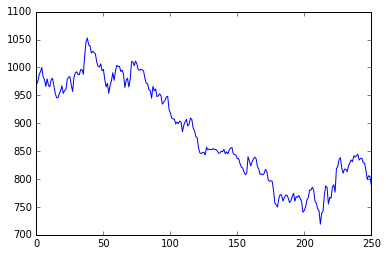

In [11]:
import matplotlib.pyplot as plt

%matplotlib inline

stock_data = load_sp500(input_size=5, num_steps=30, k=None, target_symbol='AMZN', test_ratio=0.05)

stock_data = stock_data[0]

plt.plot(stock_data.raw_seq)